In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

I am building a classifier that reads raw emails and decides whether an email is spam or ham. The goal is to read the messages and provide value to the user by removing all the emails that are spam, thus saving them time. 

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I received a zip file on Schoology for the data. When I unpacked the data, it showed hundreds of text files where each text file represents an email. The first line of each file represents the subject while the remaining lines represent the body of the email. 


In [6]:
from pathlib import Path
import pandas as pd
import re

data_dir = Path("email_archive")

def read_email(path: Path):
    text = path.read_text(encoding="utf-8", errors="ignore")
    lines = text.splitlines()

    subject = ""
    subj_idx = None
    for i, line in enumerate(lines[:10]):
        m = re.match(r'^\s*subject\s*(.*)$', line, flags=re.I)
        if m:
            subject = m.group(1).strip()
            subj_idx = i
            break

    body_lines = lines[:subj_idx] + lines[subj_idx+1:] if subj_idx is not None else lines
    body = "\n".join(body_lines).strip()
    return subject, body

file_list = sorted(list(data_dir.rglob("*.txt")))

rows = [{"path": str(p), "subject": read_email(p)[0], "body": read_email(p)[1]} for p in file_list]
df = pd.DataFrame(rows)

print("Files parsed", len(file_list))
df.head(3)


Files parsed 876


,path,subject,body
0,email_archive/.ipynb_checkpoints/3-1msg1-check...,: re : 2 . 882 s - > np np,"> deat : sun , 15 dec 91 2 : 25 : 2 est > : mi..."
1,email_archive/.ipynb_checkpoints/3-1msg2-check...,: s - > np + np,"discussion s - > np + np remind ago read , sou..."
2,email_archive/.ipynb_checkpoints/3-392msg1-che...,: humor communication : call paper,"call papers humor communication seminar sca , ..."


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

I explored the data by analyzing the basic features it has. This includes how many emails there are, how long the subjects and bodies are, how often links, addresses, and quotes appear. I also plan on noting bias like analyzing sentiment and while manually looking through the data, I noticed that a lot of the messages seem to be academic. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt

assert not df.empty, "No emails loaded"

df["subject_len"] = df["subject"].fillna("").str.len()
df["body_len"] = df["body"].fillna("").str.len()

def count_pat(s, pattern):
    return s.fillna("").str.count(pattern, flags=re.I)

df["num_urls"]   = count_pat(df["body"], r"http[s]?://|www\.")
df["num_emails"] = count_pat(df["body"], r"[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}")
df["num_quotes"] = count_pat(df["body"], r"(?m)^\s*>")

print("Total emails", len(df))
print("Empty subject", (df['subject'].fillna("")=="").sum())
print("Empty body", (df['body'].fillna("")=="").sum())

display(df[["subject_len","body_len","num_urls","num_emails","num_quotes"]].describe().round(2))


Total emails 876
Empty subject 0
Empty body 0


,subject_len,body_len,num_urls,num_emails,num_quotes
count,876.00,876.00,876.0,876.0,876.00
mean,28.22,2605.90,0.0,0.0,0.01
std,15.37,3270.39,0.0,0.0,0.09
min,1.00,14.00,0.0,0.0,0.00
25%,17.00,544.75,0.0,0.0,0.00
50%,26.00,1362.50,0.0,0.0,0.00
75%,37.00,3243.00,0.0,0.0,0.00
max,128.00,19322.00,0.0,0.0,1.00


From here, I made some plots to visualize my data and to see what I would need to clean:

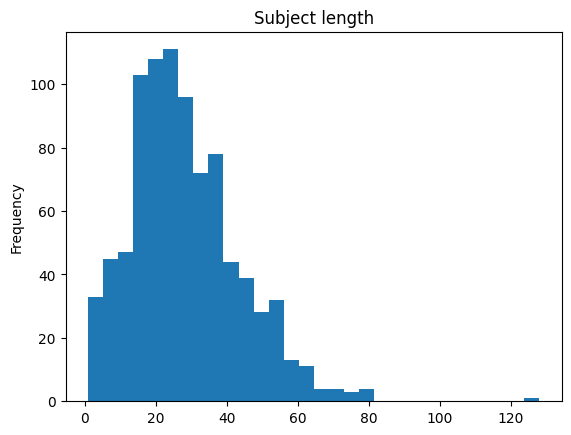

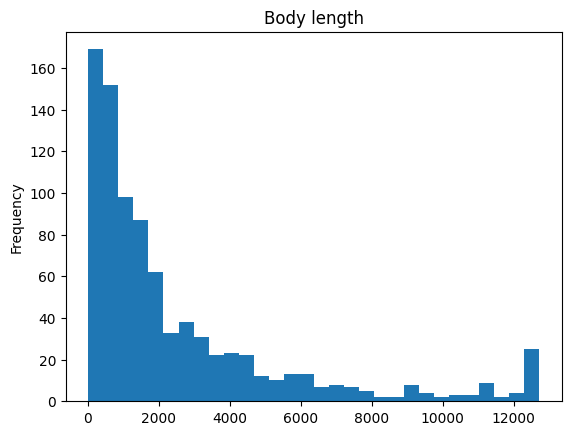

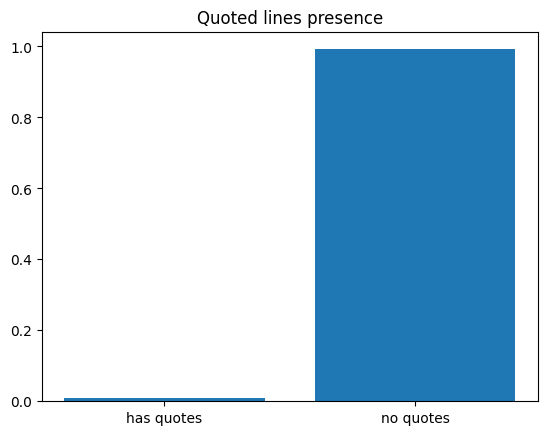

In [8]:
plt.figure(); df["subject_len"].plot(kind="hist", bins=30, title="Subject length"); plt.show()
plt.figure(); df["body_len"].clip(upper=df["body_len"].quantile(0.98)).plot(kind="hist", bins=30, title="Body length"); plt.show()
plt.figure(); plt.bar(["has quotes","no quotes"], [(df["num_quotes"]>0).mean(), 1-(df["num_quotes"]>0).mean()]); plt.title("Quoted lines presence"); plt.show()


# 4.Prepare the Data


Apply any data transformations and explain what and why

Since the quoted text appeared to be rare, I will focus on fixint spaced punctuation, normalizing case and whitespace, and mapping links and emails to tokens. Additionally I will remove header noies like the From or Date lines that leaked into the body. I kept the url and email flags and added counts of digits and currentcy symbols. Finally, I added exclamation count, word count, and a bunch of spam words as filters. The cleaned emails are saved to a separate csv file. 

In [9]:
import re
import os
import numpy as np

URL_TOKEN = ""
EMAIL_TOKEN = ""

HEADER_RE = re.compile(
    r"(?im)^(from|to|cc|bcc|date|organization|path|newsgroups|lines|message-id)\s*[:\-].*$"
)

def drop_header_like_lines(t):
    return "\n".join(
        line for line in t.splitlines()
        if not HEADER_RE.match(line.strip())
    )

def protect_urls_and_emails(t):
    t = re.sub(r"http[s]?://\S+|www\.\S+", URL_TOKEN, t, flags=re.I)
    t = re.sub(r"[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}", EMAIL_TOKEN, t, flags=re.I)
    return t

def fix_spaced_punct(t):
    t = re.sub(r"\s*([.,!?()\-+*/<>])\s*", r"\1", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

def basic_clean(t):
    if not isinstance(t, str):
        return ""
    t = t.lower()
    t = drop_header_like_lines(t)
    t = protect_urls_and_emails(t)
    t = fix_spaced_punct(t)
    return t

clean_df = df.copy()
clean_df["subject_clean"] = clean_df["subject"].apply(basic_clean)
clean_df["body_clean"]    = clean_df["body"].apply(basic_clean)

# Features that fit this set
clean_df["subject_len_chars"] = clean_df["subject_clean"].str.len()
clean_df["body_len_chars"]    = clean_df["body_clean"].str.len()
clean_df["word_count"]        = clean_df["body_clean"].str.split().str.len().fillna(0)

# Keep url and email signals from exploration
clean_df["has_url"]   = (df["num_urls"]>0).astype(int)
clean_df["has_email"] = (df["num_emails"]>0).astype(int)

# Extra lightweight signals
clean_df["num_exclaim"]  = df["body"].str.count("!").fillna(0)
clean_df["num_digits"]   = df["body"].str.count(r"\d").fillna(0)
clean_df["num_currency"] = df["body"].str.count(r"[$€£]").fillna(0)

def upper_ratio(s):
    s = s if isinstance(s, str) else ""
    letters = re.findall(r"[A-Za-z]", s)
    if not letters:
        return 0.0
    upp = sum(1 for ch in letters if ch.isupper())
    return upp / len(letters)

clean_df["upper_ratio"] = df["body"].apply(upper_ratio)

# Simple spam lexicon score
spam_words = [
    "free","win","winner","credit","offer","urgent","click","buy","deal",
    "guarantee","call","limited","money","prize","subscribe"
]
pat = re.compile(r"\b(" + "|".join(spam_words) + r")\b", flags=re.I)

def spam_score(text):
    if not isinstance(text, str):
        return 0
    return len(pat.findall(text))

clean_df["spam_lex_score"] = (clean_df["subject_clean"] + " " + clean_df["body_clean"]).apply(spam_score)

clean_df["basename"] = clean_df["path"].apply(lambda p: os.path.basename(p))
clean_df["label"] = np.where(clean_df["basename"].str.match(r"(?i)^spm"), "spam", "ham")

# Save with label included
cols = [
    "path","subject_clean","body_clean",
    "subject_len_chars","body_len_chars","word_count",
    "has_url","has_email","num_exclaim","num_digits","num_currency",
    "upper_ratio","spam_lex_score","label"
]
clean_df[cols].to_csv("emails_clean_small.csv", index=False)
print("Saved emails_clean_small.csv with", len(clean_df), "rows and labels")
clean_df[cols].head(3)


Saved emails_clean_small.csv with 876 rows and labels


,path,subject_clean,body_clean,subject_len_chars,body_len_chars,word_count,has_url,has_email,num_exclaim,num_digits,num_currency,upper_ratio,spam_lex_score,label
0,email_archive/.ipynb_checkpoints/3-1msg1-check...,: re : 2.882 s->np np,">deat : sun,15 dec 91 2 : 25 : 2 est>: michael...",21,627,77,0,0,0,13,0,0.0,0,ham
1,email_archive/.ipynb_checkpoints/3-1msg2-check...,: s->np+np,"discussion s->np+np remind ago read,source for...",10,340,41,0,0,0,9,0,0.0,0,ham
2,email_archive/.ipynb_checkpoints/3-392msg1-che...,: humor communication : call paper,"call papers humor communication seminar sca,19...",34,3334,315,0,0,0,143,0,0.0,3,ham


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


After doing some research online, I found a Kaggle webpage that achieved a 98% spam detection accuracy, so naturally, I wanted to try out the same model and see how that would perform on my dataset. Here is the link to the webpage: 

https://www.kaggle.com/code/nisargkapkar/spam-detection-with-nltk-98-1-accuracy

I turned the cleaned text data that was saved into a csv file into term frequency and inverse document frequency (TF & IDF) features and fed them into a multinomial naive bayes classifier. I split the data into train and test with stratification so that the classes are balance. Finally, I reported the acuracy, precision, recall, f1, and a confusion matrix. 

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

X = (clean_df["subject_clean"].fillna("") + " " + clean_df["body_clean"].fillna(""))
y = clean_df["label"]  # make sure this exists

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("nb", MultinomialNB(alpha=0.5))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

acc = accuracy_score(y_test, pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", pos_label="spam")
print(f"Accuracy {acc:.4f}  Precision {prec:.4f}  Recall {rec:.4f}  F1 {f1:.4f}")
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


Accuracy 0.9716  Precision 0.9744  Recall 0.9620  F1 0.9682
[[95  2]
 [ 3 76]]
              precision    recall  f1-score   support

         ham       0.97      0.98      0.97        97
        spam       0.97      0.96      0.97        79

    accuracy                           0.97       176
   macro avg       0.97      0.97      0.97       176
weighted avg       0.97      0.97      0.97       176



# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 



With the model getting almost a 98% accuracy, I was pretty surprised. I checked the code over and made sure no leakage was happening and still got the same accuracy. Now for Step 6, I ran a small grid search to pick good TF IDF settings and a good Naive Bayes alpha. The search used five fold stratified cross validation and picked the combination with the best F1 on spam detection. Then, I refit the best pipeline and scored it on the held out test set. 


In [11]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from pathlib import Path
from joblib import dump
import json

# Data
X = (clean_df["subject_clean"].fillna("") + " " + clean_df["body_clean"].fillna(""))
y = clean_df["label"].astype(str)


# Pipeline and grid
pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("nb", MultinomialNB())])
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 3],
    "tfidf__max_df": [0.9, 0.95, 1.0],
    "tfidf__sublinear_tf": [True, False],
    "nb__alpha": [0.1, 0.3, 0.5, 1.0],
}

# Tune for F1 on spam
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
spam_f1 = make_scorer(f1_score, pos_label="spam")
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring=spam_f1, cv=cv, n_jobs=-1, verbose=0)
grid.fit(X_train, y_train)

best_pipe = grid.best_estimator_
pred = best_pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
f1  = f1_score(y_test, pred, pos_label="spam")
print("Best params", grid.best_params_)
print(f"CV F1 {grid.best_score_:.4f}  Test Accuracy {acc:.4f}  Test F1 {f1:.4f}")

# Save for step 8
art = Path("artifacts"); art.mkdir(parents=True, exist_ok=True)

best_pipe.fit(X, y)
dump(best_pipe, art / "model_spam_nb_tfidf.joblib")

meta = {
    "inputs": ["subject", "body"],
    "class_names": {i: c for i, c in enumerate(best_pipe.classes_)},
    "notes": "TFIDF + MultinomialNB text pipeline"
}
(art / "meta_spam_nb_tfidf.json").write_text(json.dumps(meta))

Best params {'nb__alpha': 0.1, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}
CV F1 0.9968  Test Accuracy 0.9716  Test F1 0.9686


121

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


After cleaning the emails, I trained a TF IDF and Multinomial Bayes model. Then, after achieving an accuracy of 98%, I tuned a small grid and chose the settings with the best F1 on spam detection. On the held out test set I saw pretty much the same accuracy because I was already near the ceiling for this dataset. Multinomial Naive Bayes commonly lands around the high 90 percent range for other spam detection models on the internet, so there was likely little headroom left. I also tuned for F1 on spam rather than accuracy which would better balance precision and recall. Overall, the pipeline runs and trains fast and is simple and reliable to run in production. 


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [1]:
def inference(subject: str, body: str):
    import pandas as pd, joblib, json
    from pathlib import Path
    import numpy as np

    p = Path("./artifacts")
    m = joblib.load(p / "model_spam_nb_tfidf.joblib")
    meta = json.loads((p / "meta_spam_nb_tfidf.json").read_text())

    # single row input assembled like training
    text = f"{subject or ''} {body or ''}"
    proba = m.predict_proba([text])[0]
    pred_idx = int(np.argmax(proba))

    name_map = {int(k): v for k, v in meta["class_names"].items()}
    return {
        "predicted_class": name_map.get(pred_idx, str(pred_idx)),
        "class_probabilities": {name_map.get(i, str(i)): float(p) for i, p in enumerate(proba)}
    }
print(inference(subject="Limited time offer", body="Buy now and save big"))


{'predicted_class': 'spam', 'class_probabilities': {'ham': 0.05526368727058683, 'spam': 0.9447363127294107}}
